In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
url="/content/drive/MyDrive/Kaggle football dataset"
appearances=pd.read_csv(url+"/appearances.csv")
club_games=pd.read_csv(url+"/club_games.csv")
clubs=pd.read_csv(url+'/clubs.csv')
competitions=pd.read_csv(url+'/competitions.csv')
game_events=pd.read_csv(url+'/game_events.csv')
game_lineups=pd.read_csv(url+'/game_lineups.csv')
games=pd.read_csv(url+'/games.csv')
player_valuations=pd.read_csv(url+'/player_valuations.csv')
players=pd.read_csv(url+'/players.csv')
transfers=pd.read_csv(url+'/transfers.csv')

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
season = ['2023-2024', '2022-2023', '2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018',
          '2016-2017', '2015-2016', '2014-2015', '2013-2014',]

scrapeoutputurl = "/content/drive/MyDrive/Scrape_output/"

In [ ]:
LaLigaSquadStats = {}
LaLigaStandings = {}
LaLigaPassing = {}
LaLigaDefence = {}
LaLigaPossession = {}
LaLigaGoalShot = {}
LaLigaGoalkeeping = {}
LaLigaURL = pd.read_csv("/content/drive/MyDrive/FBref_all_links_csv/Fbref_laliga_stats_url.csv")
for url in LaLigaURL:
    k = url.rfind("/")
    file_name = url[k+1:]
    file_path = scrapeoutputurl +"LaLiga/" + file_name + ".xlsx"
    year = file_name.split("-La-Liga-Stats")[0]
    # Read all sheets
    all_sheets_dict = pd.read_excel(file_path, sheet_name=None)

    # Append relevant sheets to their respective lists
    if "Squad" in all_sheets_dict:
        #LaLigaSquadStats.append(all_sheets_dict["Squad"])
        LaLigaSquadStats[year] = all_sheets_dict["Squad"]
    if "Standings" in all_sheets_dict:
        LaLigaStandings[year] = all_sheets_dict["Standings"]
    if "Passing" in all_sheets_dict:
        LaLigaPassing[year] = all_sheets_dict["Passing"]
    if "Defence" in all_sheets_dict:
        LaLigaDefence[year] = all_sheets_dict["Defence"]
    if "Possession" in all_sheets_dict:
        LaLigaPossession[year] = all_sheets_dict["Possession"]
    if "Goal Shot" in all_sheets_dict:
        LaLigaGoalShot[year] = all_sheets_dict["Squad Shooting"]
    if "Goalkeeping" in all_sheets_dict:
        LaLigaGoalkeeping[year] = all_sheets_dict["Goalkeeping"]

In [ ]:
len(LaLigaGoalShot)

7

In [ ]:
LaLigaPlayerStats = {}
laligaplayerfilepath = scrapeoutputurl + "LaLiga/"
for year in season:
  standing_df = pd.read_excel(laligaplayerfilepath + year +"-La-Liga-Statsplayers.xlsx", sheet_name='Standings')
  passing_df = pd.read_excel(laligaplayerfilepath + year +"-La-Liga-Statsplayers.xlsx", sheet_name='Passing')
  defence_df = pd.read_excel(laligaplayerfilepath + year +"-La-Liga-Statsplayers.xlsx", sheet_name='Defence')
  possession_df = pd.read_excel(laligaplayerfilepath + year +"-La-Liga-Statsplayers.xlsx", sheet_name='Possession')
  #TODO merge all this into LaLigaPlayerstats[year]
  merged_df = passing_df.merge(defence_df, on='player', suffixes=('_passing', '_defense'))
  merged_df = merged_df.merge(possession_df, on='player', suffixes=('_defense', '_possession'))
  merged_df = merged_df.merge(standing_df, on='player', suffixes=('_possession', '_standings'))

  # Store the merged DataFrame in the dictionary for the current season
  LaLigaPlayerStats[year] = merged_df
  print(year)
  # Optional: Display the merged DataFrame for verification


2023-2024
2022-2023
2021-2022
2020-2021
2019-2020
2018-2019
2017-2018
2016-2017
2015-2016
2014-2015
2013-2014


In [ ]:
playerdata_df = LaLigaPlayerStats['2023-2024']

In [ ]:
most_common_positions = (
    game_lineups.groupby("player_id")["position"]
    .agg(lambda x: x.value_counts().idxmax() if len(x.dropna()) > 0 else None)  # Handle missing positions
    .reset_index()
    .rename(columns={"position": "field_position"})
)
# Step 1: Ensure `player_name` is unique in `player_field_positions`
# If there are duplicates, take the first occurrence or handle appropriately
player_field_positions = (
    game_lineups[["player_id", "player_name"]]
    .drop_duplicates()  # Remove duplicates
    .merge(most_common_positions, on="player_id", how="left")
)

# Step 2: Handle duplicates in `player_name`
player_field_positions = player_field_positions.drop_duplicates(subset="player_name")

# Step 3: Map `field_position` to `LaLigaPlayerstats['2023-2024']` using `player`
playerdata_df["field_position"] = playerdata_df["player"].map(
    player_field_positions.set_index("player_name")["field_position"]
)

# Verify results
print(playerdata_df[["player", "field_position"]].head())


               player field_position
0       Nabil Aberdin    Centre-Back
1               Abner      Left-Back
2         Abdel Abqar    Centre-Back
3        Marcos Acuña      Left-Back
4  Julen Agirrezabala     Goalkeeper


In [ ]:
# Create a mapping of position initials to full names (if you need one)
position_mapping = {
    "FW": "Forward",
    "MF": "Midfielder",
    "DF": "Defender",
    "GK": "Goalkeeper",
    # Add more mappings as needed
}

# Fill NaN values in 'field_position' with corresponding values from 'position' column
playerdata_df["field_position"] = playerdata_df["field_position"].fillna(
    playerdata_df["position_standings"].map(position_mapping)
)

# Verify if NaN values have been filled
nan_count_after = playerdata_df["field_position"].isna().sum()
print(f"Number of players with NaN field_position after filling: {nan_count_after}")


Number of players with NaN field_position after filling: 331848


In [ ]:
playerdata_df[]

SyntaxError: invalid syntax (<ipython-input-299-4ba6690a7d97>, line 1)

In [ ]:
columns_list = playerdata_df.columns.tolist()
print(columns_list)

In [ ]:
# Group by the 'field_position' column and count the unique values for each group
unique_counts = playerdata_df.groupby('field_position').size().reset_index(name='count')

# Display the result
print(unique_counts)


In [ ]:
midfielder_data_df = playerdata_df[playerdata_df['position_standings'].str.contains('MF', na=False)]


In [ ]:
def clean_numeric_column(df, column_name):
    """
    Cleans a numeric column by:
    - Removing commas
    - Converting to float
    - Handling NaN, empty strings, or invalid entries
    """
    df[column_name] = df[column_name].replace({',': ''}, regex=True)  # Remove commas
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')  # Convert to float; invalid entries become NaN
    df[column_name] = df[column_name].fillna(0)  # Replace NaN with 0 (or choose another strategy, e.g., mean)
    return df
# List of numeric columns to clean
numeric_columns = [
    'xg', 'goals', 'npxg_xg_assist', 'passes', 'passes_pct', 'assists_standings',
    'tackles', 'tackles_won', 'challenges', 'blocks', 'blocked_shots',
    'blocked_passes', 'interceptions', 'passes_into_final_third',
    'progressive_carries_standings', 'pass_xa', 'assisted_shots',
    'crosses_into_penalty_area', 'touches', 'take_ons_won',
    'carries_progressive_distance', 'miscontrols', 'minutes',
    'passes_total_distance', 'dispossessed'
]

# Clean all numeric columns
for col in numeric_columns:
    midfielder_data_df = clean_numeric_column(midfielder_data_df, col)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def calculate_composite_score(df, features, weights):
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize the feature columns
    df[features] = scaler.fit_transform(df[features])

    # Calculate the composite score using the weights for each feature
    df['composite_score'] = (
        df['goals'] * weights['goals'] +
        df['assists_standings'] * weights['assists'] +
        df['xg'] * weights['xg'] +
        df['passes'] * weights['passes'] +
        df['passes_pct'] * weights['passes_pct'] +
        df['minutes'] * weights['minutes'] +
        df['progressive_carries_standings'] * weights['progressive_carries_standings'] +
        df['tackles_won'] * weights['tackles_won'] +
        df['blocks'] * weights['blocks'] +
        df['blocked_shots'] * weights['blocked_shots'] +
        df['interceptions'] * weights['interceptions'] +
        df['take_ons_won'] * weights['take_ons_won'] +
        df['carries_progressive_distance'] * weights['carries_progressive_distance'] +
        df['pass_xa'] * weights['pass_xa'] +
        df['assisted_shots'] * weights['assisted_shots'] +
        df['passes_into_final_third'] * weights['passes_into_final_third'] +
        df['crosses_into_penalty_area'] * weights['crosses_into_penalty_area'] +
        df['carries'] * weights['carries'] -
        df['miscontrols'] * weights['miscontrols'] -
        df['dispossessed'] * weights['dispossessed']
    )

    return df

# Example usage:
# Define the features and weights
features = ['goals', 'assists_standings', 'xg', 'passes','passes_pct', 'minutes', 'progressive_carries_standings',
            'tackles_won', 'blocks', 'interceptions', 'take_ons_won', 'carries_progressive_distance',
            'pass_xa', 'assisted_shots', 'passes_into_final_third', 'crosses_into_penalty_area',
            'carries','blocked_shots', 'miscontrols', 'dispossessed']

weights = {
    'goals': 0.2,  # Lower for midfielders
    'assists': 0.2,  # Assists are still key
    'xg': 0.15,  # xG can be critical for attacking midfielders
    'passes': 0.05,  # Slightly more importance
    'passes_pct': 0.05,  # Passing accuracy matters
    'minutes': 0.03,  # Consistency
    'progressive_carries_standings': 0.1,
    'tackles_won': 0.12,
    'blocks': 0.08,
    'blocked_shots': 0.05,
    'interceptions': 0.15,
    'take_ons_won': 0.1,  # Ability to beat players
    'carries_progressive_distance': 0.1,
    'pass_xa': 0.15,  # Key passes for assists
    'assisted_shots': 0.08,
    'passes_into_final_third': 0.15,
    'crosses_into_penalty_area': 0.08,
    'carries': 0.1,
    'miscontrols': 0.1,  # Reduced penalty
    'dispossessed': 0.1
}

# Assuming you have a DataFrame `midfielder_data_df_df`
# Apply the function to calculate the composite score
midfielder_data_df = calculate_composite_score(midfielder_data_df, features, weights)

midfielder_data_df.head()


,ranker_passing,player,nationality_passing,position_passing,team_passing,age_passing,birth_year_passing,minutes_90s_passing,passes_completed,passes,...,goals_pens_per90,goals_assists_pens_per90,xg_per90,xg_assist_per90,xg_xg_assist_per90,npxg_per90,npxg_xg_assist_per90,matches_standings,field_position,composite_score
5,6,Lucien Agoume,fr FRA,MF,Sevilla,21.0,2002.0,8.6,301.0,0.117570,...,0.00,0.00,0.10,0.07,0.17,0.10,0.17,Matches,Midfielder,0.182969
7,8,Ilias Akhomach,ma MAR,"MF,FW",Villarreal,19.0,2004.0,16.8,372.0,0.157087,...,0.12,0.24,0.19,0.15,0.34,0.19,0.34,Matches,Right Winger,0.378975
9,10,Paul Akouokou,ci CIV,MF,Betis,25.0,1997.0,0.3,16.0,0.005552,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Matches,Defensive Midfield,0.062236
12,13,Rubén Alcaraz,es ESP,MF,Cádiz,32.0,1991.0,34.8,1271.0,0.516656,...,0.03,0.06,0.09,0.04,0.13,0.05,0.09,Matches,Central Midfield,0.650085
14,15,Iván Alejo,es ESP,MF,Cádiz,28.0,1995.0,18.8,245.0,0.157087,...,0.00,0.11,0.03,0.07,0.10,0.03,0.10,Matches,Right Winger,0.314079


In [ ]:
# Sort players by composite metric in descending order
top_midfielders = midfielder_data_df.sort_values(by='composite_score', ascending=False)

# Display the top players
print(top_midfielders[['player', 'composite_score']].head(10))


# Display the dataframe with composite scores
print(midfielder_data_df[['xg', 'npxg_xg_assist', 'passes', 'assists_standings', 'tackles', 'tackles_won', 'composite_score']])

                    player  composite_score
76         Jude Bellingham         0.999456
298         İlkay Gündoğan         0.995640
241           Aleix García         0.989348
642                  Sávio         0.972093
715  José Luis García Vayá         0.943194
713      Federico Valverde         0.928409
347             Toni Kroos         0.874990
61              Alex Baena         0.868598
286      Antoine Griezmann         0.812908
614       Kirian Rodríguez         0.774878
           xg  npxg_xg_assist    passes  assists_standings  tackles  \
5    0.073171             1.5  0.117570           0.000000     23.0   
7    0.260163             5.7  0.157087           0.142857     36.0   
9    0.000000             0.0  0.005552           0.000000      5.0   
12   0.268293             3.1  0.516656           0.071429     97.0   
14   0.040650             1.8  0.157087           0.142857     40.0   
..        ...             ...       ...                ...      ...   
760  0.154472      

In [ ]:
columns_list = midfielder_data_df.columns.tolist()
print(columns_list)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb


# Define feature columns and target
features = ['xg','goals','npxg_xg_assist','passes', 'passes_pct','assists_standings', 'tackles', 'tackles_won', 'challenges','blocks','blocked_shots',
            'blocked_passes','interceptions','passes_into_final_third','progressive_carries_standings','pass_xa','assisted_shots','crosses_into_penalty_area',
            'touches','take_ons_won','carries_progressive_distance','miscontrols','minutes', 'field_position','passes_total_distance','dispossessed']

target = 'composite_score'  # Assume you're predicting a composite score for performance

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [ 'passes', 'touches', 'minutes','passes_total_distance']),
        ('cat', OneHotEncoder(), ['field_position'])  # Encoding the position column
    ])
# XGBoost model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

# Train-test split
X = midfielder_data_df[features]
y = midfielder_data_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f'R-squared: {score}')


R-squared: 0.8177940321188926


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

features = ['xg','goals','npxg_xg_assist','passes', 'passes_pct','assists_standings', 'tackles', 'tackles_won','interceptions', 'challenges','blocks','blocked_shots',
            'blocked_passes','interceptions','passes_into_final_third','progressive_carries_standings','pass_xa','assisted_shots','crosses_into_penalty_area',
            'touches','take_ons_won','carries_progressive_distance','miscontrols','minutes', 'position_standings','passes_total_distance','dispossessed']
target = 'composite_score'  # Assume you're predicting a composite score for performance

# Convert 'position_standings' to categorical dtype
midfielder_data_df['position_standings'] = midfielder_data_df['position_standings'].astype('category')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['challenges', 'progressive_carries_standings', 'carries_progressive_distance', 'passes', 'touches', 'minutes', 'passes_total_distance']),
        ('cat', OneHotEncoder(), ['position_standings'])  # Encoding the position column
    ])

# Create XGBoost model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1,enable_categorical=True))
])

# Train-test split
X = midfielder_data_df[features]
y = midfielder_data_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
features = [f for f in features if f in X_train.columns]  # Remove missing features from the list

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mae}")
# Assuming 'model' is your pipeline and 'xgboost' is the name of your regressor step
xgb_model = model.named_steps['regressor']  # Access the XGBRegressor model

# Now, you can get the feature importances
importances = xgb_model.feature_importances_

# Assuming you have a list of feature names
# Combine features and their corresponding importances into a dictionary
feature_weights = dict(zip(features, importances))
print("Feature Weights:", feature_weights)


R-squared: 0.8795997265277333
Mean Absolute Error: 0.04003513368654802
Feature Weights: {'xg': 0.0064431466, 'goals': 0.012344482, 'npxg_xg_assist': 0.09220243, 'passes': 0.028089311, 'passes_pct': 0.19654123, 'assists_standings': 0.64380556, 'tackles': 0.005249677, 'tackles_won': 0.0018167491, 'interceptions': 0.0033847285, 'challenges': 0.007989228, 'blocks': 0.00047324682, 'blocked_shots': 0.0016602756}


In [ ]:
print(X_train.columns)
features = [f for f in features if f in X_train.columns]  # Remove missing features from the list


Index(['goals_for', 'goals_against', 'goal_diff', 'xg_x', 'shots', 'xg_diff',
       'shots_on_target', 'possession', 'progressive_passes_y', 'passes_pct',
       'shots', 'previous_season_rank', 'previous_season_goal_diff',
       'previous_season_points'],
      dtype='object')


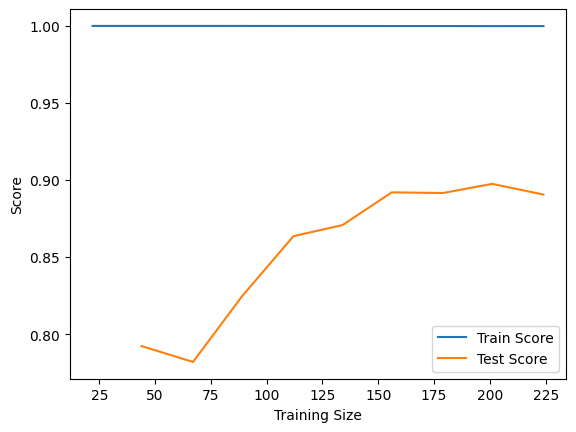

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()


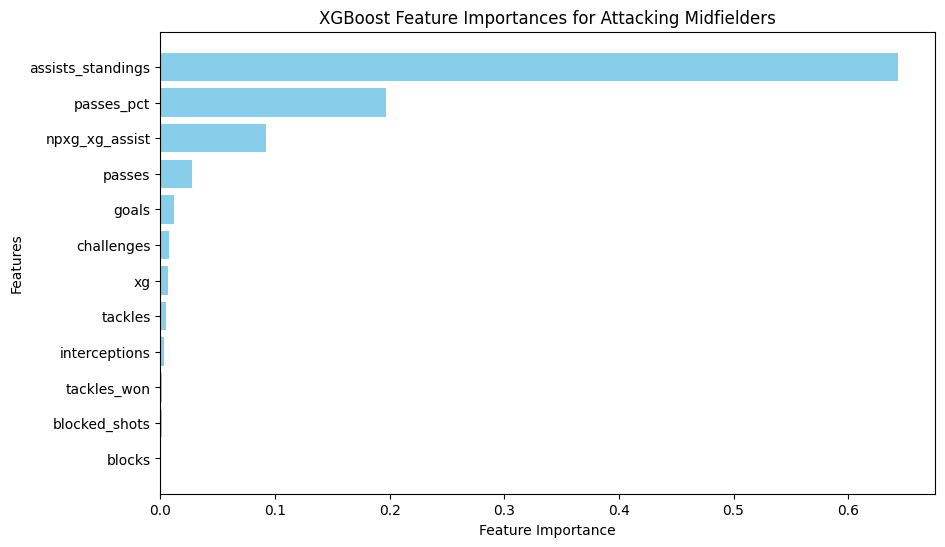

In [ ]:
import matplotlib.pyplot as plt

# Sort feature importances for better visualization
sorted_features = sorted(feature_weights.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_features)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importances for Attacking Midfielders")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()


In [ ]:
# Get the feature names from the preprocessor
num_features = ['xg', 'passes', 'assists_standings', 'tackles', 'tackles_won', 'blocks',
                'interceptions', 'progressive_carries_standings', 'touches', 'minutes']
cat_features = ['position_standings']

# Get the transformed feature names
encoded_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features)
all_features = num_features + list(encoded_features)

# Retrieve feature importances
xgb_model = model.named_steps['regressor']
importances = xgb_model.feature_importances_

# Combine features and their corresponding importances into a dictionary
feature_weights = dict(zip(all_features, importances))
print("Feature Weights:", feature_weights)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Feature Weights from the regressor model
feature_weights = {
    'xg': 0.0028074777,
    'npxg_xg_assist': 0.014511271,
    'passes': 0.02521498,
    'assists_standings': 0.049079727,
    'tackles': 0.0041066767,
    'tackles_won': 0.0021202709,
    'challenges': 0.006845604,
    'blocks': 0.0032814222,
    'blocked_shots': 0.0037483529,
    'blocked_passes': 0.0035554038,
    'interceptions': 0.0039012823,
    'passes_into_final_third': 0.00104916,
    'progressive_carries_standings': 0.0051578134,
    'touches': 0.25811186,
    'take_ons_won': 0.0017958903,
    'carries_progressive_distance': 0.085224025,
    'miscontrols': 0.0011788538,
    'minutes': 0.5146986,
    'position_standings': 0.011747699,
    'passes_total_distance': 2.458117e-05
}
feature_weights: {'xg': 0.006162409, 'goals': 0.010427738, 'npxg_xg_assist': 0.07742958, 'passes': 0.026498582, 'passes_pct': 0.17213306, 'assists_standings': 0.6811162, 'tackles': 0.0061150487, 'tackles_won': 0.004077891, 'interceptions': 0.00217005, 'challenges': 0.011250096, 'blocks': 0.00095857604, 'blocked_shots': 0.001660768}
# Calculate the composite score using the weights
midfielder_data_df['composite_score'] = (
    feature_weights['xg'] * midfielder_data_df['xg'] +
    feature_weights['npxg_xg_assist'] * midfielder_data_df['npxg_xg_assist'] +
    feature_weights['passes'] * midfielder_data_df['passes'] +
    feature_weights['assists_standings'] * midfielder_data_df['assists_standings'] +
    feature_weights['tackles'] * midfielder_data_df['tackles'] +
    feature_weights['tackles_won'] * midfielder_data_df['tackles_won'] +
    feature_weights['challenges'] * midfielder_data_df['challenges'] +
    feature_weights['blocks'] * midfielder_data_df['blocks'] +
    feature_weights['blocked_shots'] * midfielder_data_df['blocked_shots'] +
    feature_weights['blocked_passes'] * midfielder_data_df['blocked_passes'] +
    feature_weights['interceptions'] * midfielder_data_df['interceptions'] +
    feature_weights['passes_into_final_third'] * midfielder_data_df['passes_into_final_third'] +
    feature_weights['progressive_carries_standings'] * midfielder_data_df['progressive_carries_standings'] +
    feature_weights['touches'] * midfielder_data_df['touches'] +
    feature_weights['take_ons_won'] * midfielder_data_df['take_ons_won']
)

# Display the dataframe with composite scores
print(midfielder_data_df[['xg', 'npxg_xg_assist', 'passes', 'assists_standings', 'tackles', 'tackles_won', 'composite_score']])


In [ ]:
# Sort players by composite metric in descending order
top_centerforwards = midfielder_data_df.sort_values(by='composite_score', ascending=False)

# Display the top players
print(top_centerforwards[['player', 'composite_score','team_standings']].head(10))


# TEAM:

In [ ]:
import pandas as pd

# Assuming LaLigaSquadStats and LaLigaStandings are dictionaries where keys are seasons
# LaLigaSquadStats = {'2023-2024': ..., '2022-2023': ..., ...}
# LaLigaStandings = {'2023-2024': ..., '2022-2023': ..., ...}

# Initialize an empty list to store the combined DataFrames
combined_season_dfs = []
season = ['2023-2024', '2022-2023', '2021-2022', '2020-2021', '2019-2020', '2018-2019', '2017-2018']

# Iterate through each season
for year in season:
    # Extract the squad stats and standings for the current season
    squad_stats = pd.DataFrame(LaLigaSquadStats[year])
    standings = pd.DataFrame(LaLigaStandings[year])
    passing = pd.DataFrame(LaLigaPassing[year])
    shooting = pd.DataFrame(LaLigaGoalShot[year])

    # Add the 'season' column to both dataframes before merging
    squad_stats['season'] = year
    standings['season'] = year
    passing['season'] = year
    shooting['season'] = year
    # Merge the squad stats and standings dataframes on 'team_name' and 'season'
    # Merge squad_stats and standings on 'team' and 'season'
    merged_df = pd.merge(squad_stats, standings, on=['team', 'season'], how='inner')

    # Merge passing stats on 'team' and 'season'
    merged_df = pd.merge(merged_df, passing, on=['team', 'season'], how='inner')

    # Merge shooting stats on 'team' and 'season'
    merged_df = pd.merge(merged_df, shooting, on=['team', 'season'], how='inner')
    # Append the merged DataFrame to the list
    combined_season_dfs.append(merged_df)

# Concatenate all seasons into a single DataFrame
combined_df = pd.concat(combined_season_dfs, ignore_index=True)

# Display the combined DataFrame with the new 'season' column
print(combined_df.columns)


Index(['team', 'players_used_x', 'avg_age', 'possession', 'games_x',
       'games_starts', 'minutes', 'minutes_90s_x', 'goals_x', 'assists_x',
       'goals_assists', 'goals_pens', 'pens_made_x', 'pens_att_x',
       'cards_yellow', 'cards_red', 'xg_x', 'npxg_x', 'xg_assist_x',
       'npxg_xg_assist', 'progressive_carries', 'progressive_passes_x',
       'goals_per90', 'assists_per90', 'goals_assists_per90',
       'goals_pens_per90', 'goals_assists_pens_per90', 'xg_per90',
       'xg_assist_per90', 'xg_xg_assist_per90', 'npxg_per90',
       'npxg_xg_assist_per90', 'season', 'rank', 'games_y', 'wins', 'ties',
       'losses', 'goals_for', 'goals_against', 'goal_diff', 'points',
       'points_avg', 'xg_for', 'xg_against', 'xg_diff', 'xg_diff_per90',
       'attendance_per_g', 'top_team_scorers', 'top_keeper', 'notes',
       'players_used_y', 'minutes_90s_y', 'passes_completed', 'passes',
       'passes_pct', 'passes_total_distance', 'passes_progressive_distance',
       'passes_comp

In [ ]:

# Calculate the change in team performance (lag features for the previous season)
combined_df['previous_season_goal_diff'] = combined_df.groupby('team')['goal_diff'].shift(1)
combined_df['previous_season_points'] = combined_df.groupby('team')['points'].shift(1)
combined_df['previous_season_possession'] = combined_df.groupby('team')['possession'].shift(1)
combined_df['previous_season_rank'] = combined_df.groupby('team')['rank'].shift(1)
# Drop rows where previous season data is missing (e.g., first season for a team)
combined_df = combined_df.dropna(subset=['previous_season_goal_diff', 'previous_season_points', 'previous_season_possession'])

combined_df['rank_improvement'] = (combined_df['rank'] < combined_df['previous_season_rank']).astype(int)
combined_df['goal_diff_improvement'] = (combined_df['goal_diff'] > combined_df['previous_season_goal_diff']).astype(int)
combined_df['points_improvement'] = (combined_df['points'] > combined_df['previous_season_points']).astype(int)

# You can choose which target variable to focus on based on the specific task.
# For now, we will combine all improvements into a single improvement indicator:
combined_df['team_improvement'] = combined_df[['rank_improvement', 'goal_diff_improvement', 'points_improvement']].sum(axis=1)
combined_df['team_improvement'] = (combined_df['team_improvement'] > 1).astype(int)  # If any of the improvements are true, mark as improved


# Display the updated DataFrame
print(combined_df.head())

# You can choose which target variable to focus on based on the specific task.
# For now, we will combine all improvements into a single improvement indicator:
combined_df['team_improvement'] = combined_df[['rank_improvement', 'goal_diff_improvement', 'points_improvement']].sum(axis=1)
combined_df['team_improvement'] = (combined_df['team_improvement'] > 1).astype(int)  # If any of the improvements are true, mark as improved


               team  players_used_x  avg_age  possession  games_x  \
20          Almería              29     26.4        45.1       38   
21    Athletic Club              26     27.4        51.6       38   
22  Atlético Madrid              27     28.5        50.6       38   
23        Barcelona              29     25.9        64.3       38   
24            Betis              30     28.6        50.6       38   

    games_starts minutes  minutes_90s_x  goals_x  assists_x  ...  xg_net  \
20           418   3,420           38.0       49         33  ...     3.5   
21           418   3,420           38.0       46         33  ...    -8.2   
22           418   3,420           38.0       68         51  ...     6.1   
23           418   3,420           38.0       69         56  ...    -6.5   
24           418   3,420           38.0       43         26  ...    -8.3   

    npxg_net  previous_season_goal_diff  previous_season_points  \
20       3.8                      -32.0                    21

In [ ]:
print(combined_df.columns)

Index(['team', 'players_used_x', 'avg_age', 'possession', 'games_x',
       'games_starts', 'minutes', 'minutes_90s_x', 'goals_x', 'assists_x',
       ...
       'xg_net', 'npxg_net', 'previous_season_goal_diff',
       'previous_season_points', 'previous_season_possession',
       'previous_season_rank', 'rank_improvement', 'goal_diff_improvement',
       'points_improvement', 'team_improvement'],
      dtype='object', length=103)


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Prepare the data
# Feature columns: We'll use various team performance metrics as features (feel free to customize)
features = [
    'goals_for', 'goals_against', 'goal_diff', 'xg_x', 'shots', 'xg_diff', 'shots_on_target',
    'possession', 'progressive_passes_y', 'passes_pct', 'shots','previous_season_rank',
    'previous_season_goal_diff', 'previous_season_points'
]

# Target variable: team_improvement
X = combined_df[features]
y = combined_df['team_improvement']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model (Baseline)
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluation Metrics for Logistic Regression
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

# Random Forest Classifier Model (Final Model)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics for Random Forest Classifier
print("\nRandom Forest Classifier - Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.78      0.88        18

    accuracy                           0.83        23
   macro avg       0.78      0.89      0.79        23
weighted avg       0.90      0.83      0.84        23

AUC-ROC: 0.8888888888888888
Accuracy: 0.8260869565217391

Random Forest Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.80      0.57         5
           1       0.93      0.72      0.81        18

    accuracy                           0.74        23
   macro avg       0.69      0.76      0.69        23
weighted avg       0.82      0.74      0.76        23

AUC-ROC: 0.7611111111111112
Accuracy: 0.7391304347826086


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Define the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider at each split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters found: ", grid_search.best_params_)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_rf_best = best_rf_model.predict(X_test)

# Evaluate the best model
print("\nRandom Forest with GridSearchCV - Classification Report:")
print(classification_report(y_test, y_pred_rf_best))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_rf_best))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_best))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Random Forest with GridSearchCV - Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.60      0.40         5
           1       0.85      0.61      0.71        18

    accuracy                           0.61        23
   macro avg       0.57      0.61      0.55        23
weighted avg       0.73      0.61      0.64        23

AUC-ROC: 0.6055555555555556
Accuracy: 0.6086956521739131


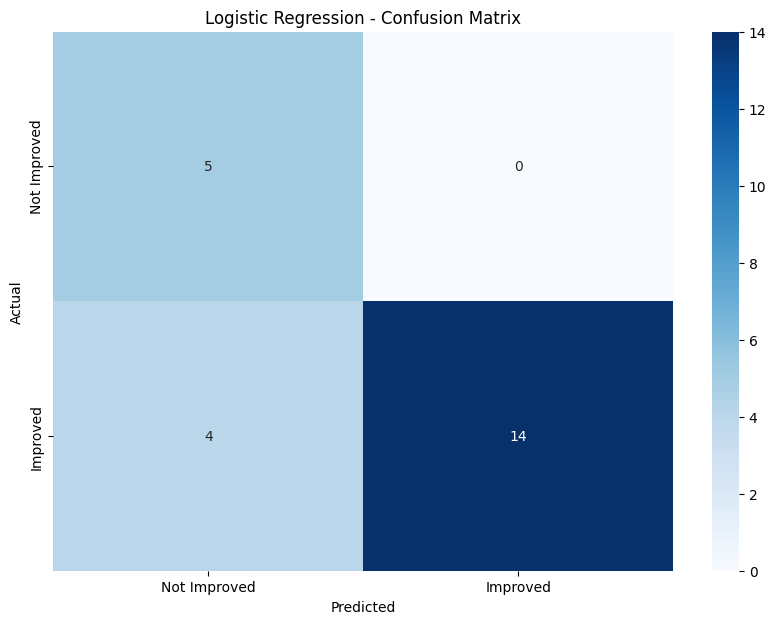

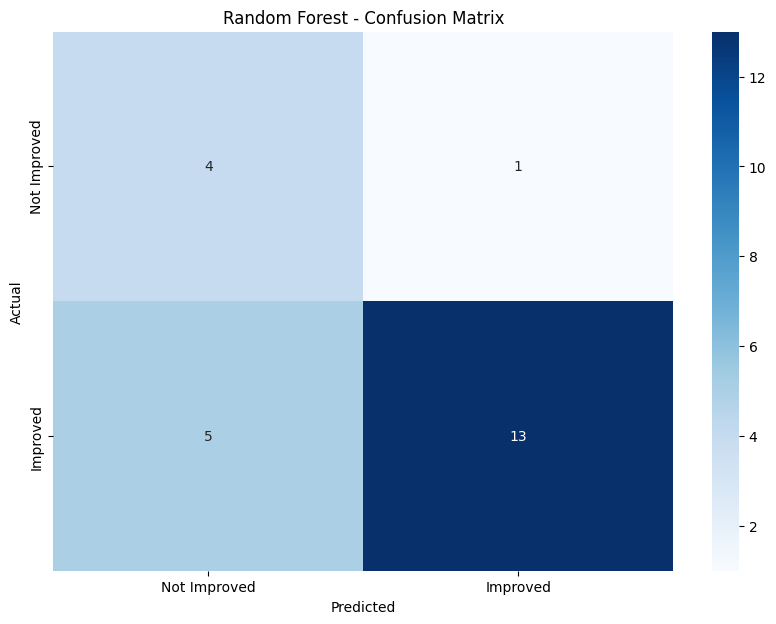

In [ ]:
# Assuming your models are named `log_reg` and `rf`

log_reg_cm = confusion_matrix(y_test, logreg_model.predict(X_test))
rf_cm = confusion_matrix(y_test, rf_model.predict(X_test))

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(10, 7))
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Improved', 'Improved'], yticklabels=['Not Improved', 'Improved'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot confusion matrix for Random Forest
plt.figure(figsize=(10, 7))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Improved', 'Improved'], yticklabels=['Not Improved', 'Improved'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


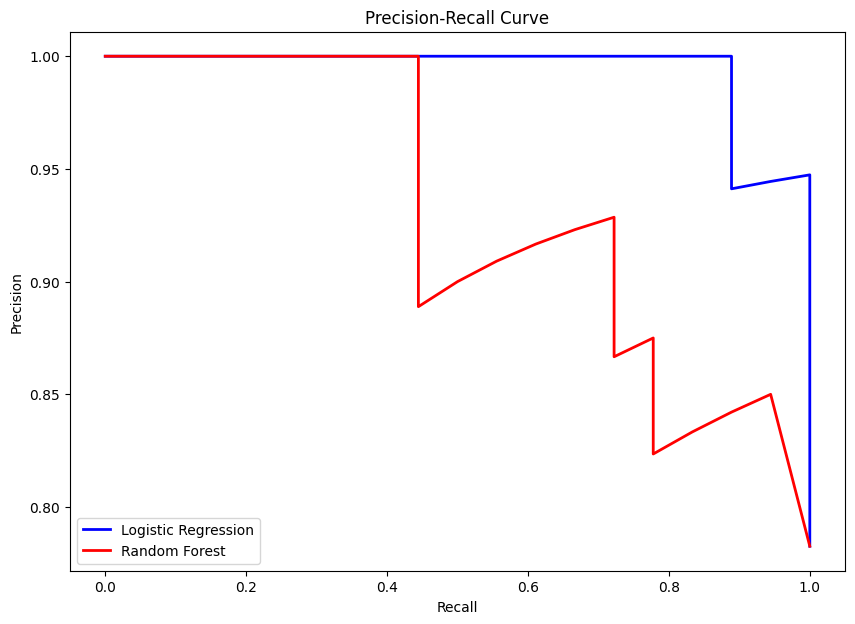

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve for both models
log_reg_precision, log_reg_recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test)[:, 1])
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(log_reg_recall, log_reg_precision, color='blue', lw=2, label=f'Logistic Regression')
plt.plot(rf_recall, rf_precision, color='red', lw=2, label=f'Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


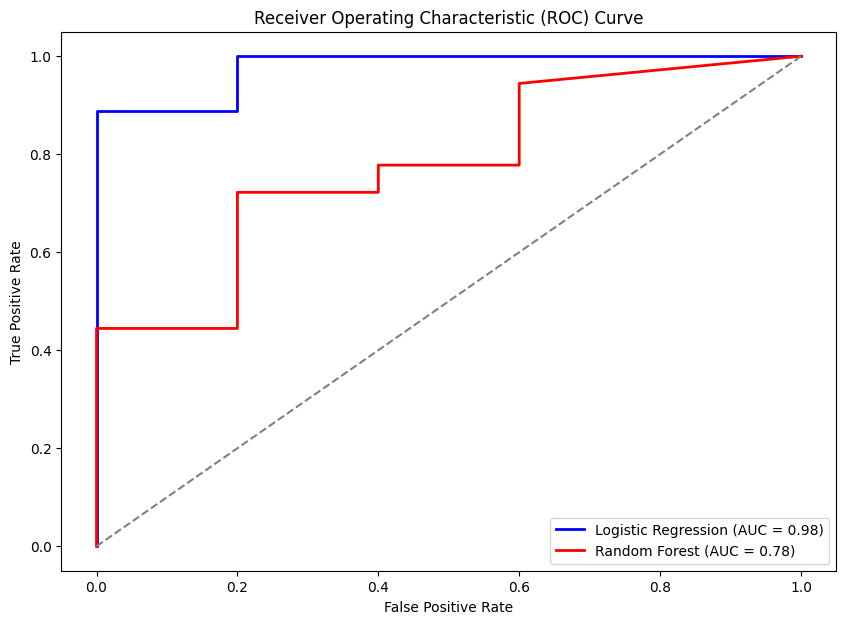

In [ ]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve for both models
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])

# Compute AUC for both models
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(log_reg_fpr, log_reg_tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='red', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
